<a href="https://colab.research.google.com/github/pavankumar2004/Track-and-Count-vehicles-with-yolov8-and-supervision/blob/main/Copy_of_how_to_track_and_count_vehicles_with_yolov8_and_supervison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Jul 18 08:31:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download video

In [ ]:
!pip install -q gdown
%cd {HOME}
!gdown '1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'

[Errno 2] No such file or directory: '{HOME}'
/content
Downloading...
From: https://drive.google.com/uc?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
To: /content/vehicle-counting.mp4
100% 35.3M/35.3M [00:00<00:00, 113MB/s]


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

## Install YOLOv8

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.59 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/78.2 GB disk)


## Install Roboflow Supervision

In [ ]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.22.0


## Load pre-trained YOLOv8 model

In [ ]:
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 176MB/s]


YOLOv8x summary (fused): 268 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
print(CLASS_NAMES_DICT)

# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [1,2, 3, 5, 7]

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [ ]:
import supervision as sv
import numpy as np

Label: ['truck 0.93', 'car 0.90', 'car 0.86', 'car 0.78']


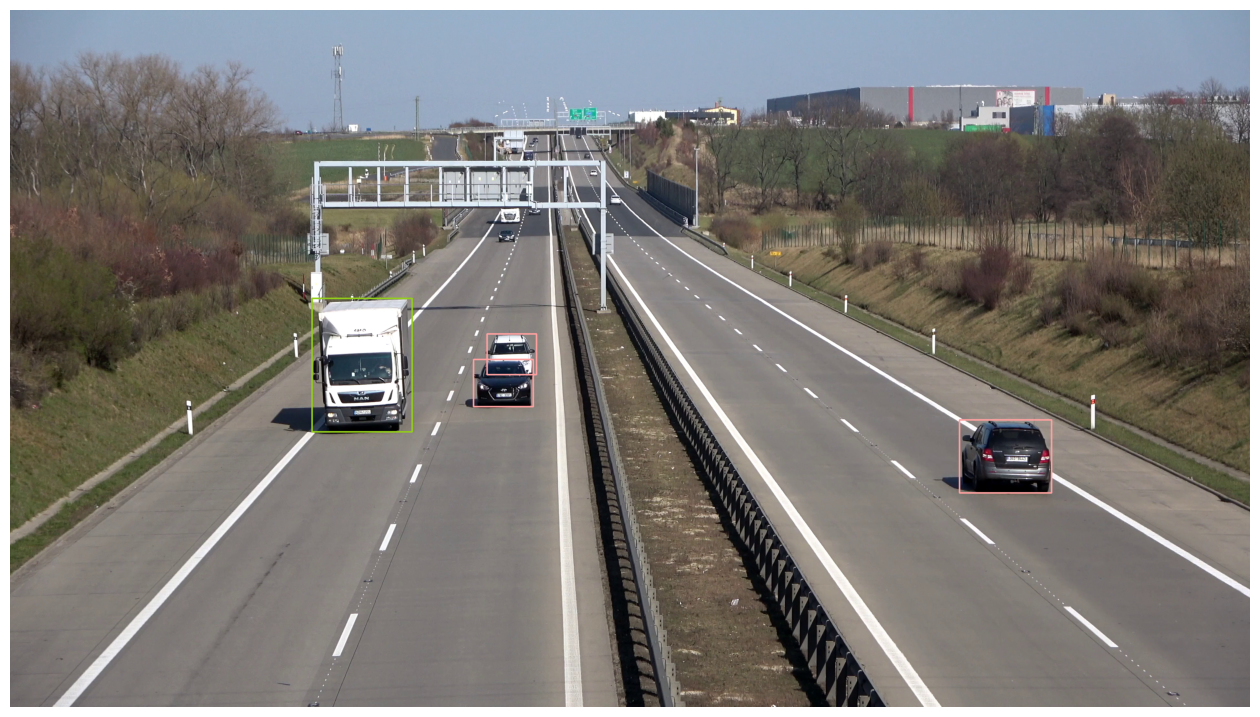

In [ ]:
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
#print("Iterator:",iterator,"Frame:",frame)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]
#print("Results:",results)
# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, selected_classes)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]
print("Label:",labels)
# annotate and display frame
anotated_frame=box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.plot_image(anotated_frame, (16,16))

## Predict and annotate whole video

In [ ]:
# settings
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result-with-counter.mp4"

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(track_activation_threshold=0.25, lost_track_buffer=30, minimum_matching_threshold=0.8, frame_rate=30)

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)

# create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )
    annotated_frame=box_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        )

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return  line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

In [ ]:
import os
import numpy as np
import ultralytics
import supervision as sv
import cv2
from IPython import display

# Paths
HOME = os.getcwd()
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"
TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result-with-counter.mp4"

# Download video
!pip install -q gdown
import gdown
gdown.download('https://drive.google.com/uc?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-', output=SOURCE_VIDEO_PATH, quiet=False)

# Install necessary packages
!pip install -q ultralytics supervision

# Load YOLOv8 model
MODEL = "yolov8x.pt"
model = ultralytics.YOLO(MODEL)
model.fuse()

# Selected classes: car, motorcycle, bus, and truck
CLASS_NAMES_DICT = model.model.names
selected_classes = [2, 3, 5, 7]

# Create BYTETracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

# Create LineZone instance
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Annotators
box_annotator = sv.BoxAnnotator(thickness=4)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Vehicle counters
vehicle_counters = {class_id: 0 for class_id in selected_classes}

# Callback function
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, selected_classes)]
    detections = byte_tracker.update_with_detections(detections)

    # Update vehicle counters
    for detection in detections:
        class_id = detection[2]  # Accessing class_id from the tuple
        if class_id in vehicle_counters:
            vehicle_counters[class_id] += 1

    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    line_zone.trigger(detections)

    # Annotate frame with vehicle counters
    for class_id, count in vehicle_counters.items():
        class_name = CLASS_NAMES_DICT[class_id]
        cv2.putText(annotated_frame, f"{class_name}: {count}", (10, 30 * (class_id + 1)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Process the video
sv.process_video(source_path=SOURCE_VIDEO_PATH, target_path=TARGET_VIDEO_PATH, callback=callback)

# Print completion message
print(f"Processed video saved to: {TARGET_VIDEO_PATH}")


Downloading...
From: https://drive.google.com/uc?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
To: /content/vehicle-counting.mp4
100%|██████████| 35.3M/35.3M [00:00<00:00, 171MB/s]


YOLOv8x summary (fused): 268 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


SupervisionWarnings: `track_buffer` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'lost_track_buffer' instead.
SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: `match_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'minimum_matching_threshold' instead.


Processed video saved to: /content/vehicle-counting-result-with-counter.mp4


In [ ]:
import cv2

from ultralytics import YOLO, solutions
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"
TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result-with-counter.mp4"

model = YOLO("yolov8n.pt")
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
assert cap.isOpened(), "Error reading video file"
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

line_points = [(20, 400), (1080, 400)] # line or region points
classes_to_count = [0, 2] # person and car classes for count

# Video writer
video_writer = cv2.VideoWriter("object_counting_output.avi", cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

# Init Object Counter
counter = solutions.ObjectCounter(
    view_img=True,
    reg_pts=line_points,
    names=model.names,
    draw_tracks=True,
    line_thickness=2,
)

while cap.isOpened():
    success, im0 = cap.read()
    if not success:
        print("Video frame is empty or video processing has been successfully completed.")
        break
    tracks = model.track(im0, persist=True, show=False, classes=classes_to_count)

    im0 = counter.start_counting(im0, tracks)
    video_writer.write(im0)

cap.release()
video_writer.release()
cv2.destroyAllWindows()




ModuleNotFoundError: No module named 'ultralytics'

In [ ]:
from google.colab import files
files.download('/content/object_counting_output.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
from ultralytics import YOLO, solutions

SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"
TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result-with-counter.mp4"

model = YOLO("yolov8n.pt")
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
assert cap.isOpened(), "Error reading video file"
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

line_points = [(20, 400), (1080, 400)] # line or region points
classes_to_count = [2, 5, 7] # car, bus, and truck classes for count

# Video writer
video_writer = cv2.VideoWriter(TARGET_VIDEO_PATH, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

# Init Object Counter
counter = solutions.ObjectCounter(
    view_img=True,
    reg_pts=line_points,
    names=model.names,
    draw_tracks=True,
    line_thickness=2,
)

# Vehicle counters
vehicle_counters = {class_id: 0 for class_id in classes_to_count}

while cap.isOpened():
    success, im0 = cap.read()
    if not success:
        print("Video frame is empty or video processing has been successfully completed.")
        break

    tracks = model.track(im0, persist=True, show=False, classes=classes_to_count)

    # Debug: print structure of tracks
    print(f"Tracks: {tracks}")

    # Count each vehicle type
    for track in tracks:
        print(f"Track: {track}")  # Debug: print each track
        # Assuming track is a tuple (track_id, class_id, confidence, bbox)
        class_id = track[0] if len(track) > 2 else None  # Access class_id correctly
        if class_id in vehicle_counters:
            vehicle_counters[class_id] += 1

    im0 = counter.start_counting(im0, tracks)

    # Annotate frame with vehicle counters
    for idx, (class_id, count) in enumerate(vehicle_counters.items()):
        class_name = model.names[class_id]
        cv2.putText(im0, f"{class_name}: {count}", (10, 30 * (idx + 1)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    video_writer.write(im0)

cap.release()
video_writer.release()
cv2.destroyAllWindows()

print(f"Processed video saved to: {TARGET_VIDEO_PATH}")


Streaming output truncated to the last 5000 lines.
Speed: 3.2ms preprocess, 24.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Tracks: [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 4

In [ ]:
import cv2
from ultralytics import YOLO, solutions

# File paths
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"
TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result-with-counter.mp4"

# Load the YOLO model
model = YOLO("yolov8n.pt")

# Open the video file
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
assert cap.isOpened(), "Error reading video file"
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

# Define line points and classes to count (car, bus, and truck)
line_points = [(20, 400), (1080, 400)]
classes_to_count = [2, 5, 7]  # Car, bus, and truck class IDs

# Initialize video writer
video_writer = cv2.VideoWriter(TARGET_VIDEO_PATH, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

# Initialize Object Counter
counter = solutions.ObjectCounter(
    view_img=True,
    reg_pts=line_points,
    names=model.names,
    draw_tracks=True,
    line_thickness=2,
)

# Initialize vehicle counters
vehicle_counters = {class_id: 0 for class_id in classes_to_count}

while cap.isOpened():
    success, im0 = cap.read()
    if not success:
        print("Video frame is empty or video processing has been successfully completed.")
        break

    # Perform tracking on the frame
    tracks = model.track(im0, persist=True, show=False, classes=classes_to_count)

    # Count each vehicle type
    for track in tracks:
        # Assuming track is a dictionary with keys 'class_id' and 'track_id'
        if isinstance(track, dict):
            class_id = track.get('class_id', None)
            if class_id in vehicle_counters:
                vehicle_counters[class_id] += 1

    # Perform counting and annotation
    im0 = counter.start_counting(im0, tracks)

    # Annotate frame with vehicle counters
    for idx, (class_id, count) in enumerate(vehicle_counters.items()):
        class_name = model.names[class_id]
        cv2.putText(im0, f"{class_name}: {count}", (10, 30 * (idx + 1)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    video_writer.write(im0)

cap.release()
video_writer.release()
cv2.destroyAllWindows()

print(f"Processed video saved to: {TARGET_VIDEO_PATH}")


ModuleNotFoundError: No module named 'ultralytics'

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.